
 # Homework 04

 **Student**: Kalin Gibbons

 **Course Instructor**: John Chiasson

 **Author (TA)**: Ruthvik Vaila

 > Note:
 > * In this notebook we shall load a large `NumPy` array directly into RAM to
 >   train a model.
 >
 > * While the model is training keep an eye on the time taken and RAM usage
 >   of your machine.
 >
 > * Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`.
 >
 > * Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`.


 ## First we must import and configure Keras and the Tensorflow backend


In [1]:
import gzip
import os
import pickle
import sys
import warnings
from pathlib import Path

import IPython
import IPython.display as display
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Conv2D,
                                     Dropout,
                                     Flatten,
                                     Dense,
                                     MaxPooling2D)
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib



Using TensorFlow backend.



 ## Configure Keras

 Filtering the warning messages is important, because the Tensorflow team love
 to leave extensive deprecation messages all over their repository. We also
 need to configure tensorflow to use a CUDA enabled GPU. Specifically we need
 to:

 1. Create a setting allowing the end user to toggle between GPU or CPU.
 2. Force `tensorflow` to allocate a small amount of GPU memory, then increase
    the allocation, as needed. Otherwise it will default to all available
    memory, and compete with the computer display. See this [github
    issue](https://github.com/tensorflow/tensorflow/issues/24828).
 3. Leave in a toggle for using _eager-execution_, for debugging purposes.

In [2]:
print(sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # setting it to -1 hides the GPU.
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# tf.compat.v1.enable_eager_execution()

# Tensorflow-GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Print out some diagnostic information about the host machine
print(f'TF version:{tf.__version__}, Keras version:{keras.__version__}\n')
device_lib.list_local_devices()



3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
TF version:1.15.0, Keras version:2.2.4



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11329891345593630496,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6588305899
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15320558394674183175
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5"]


 ## Load the data

 > Note:
 > There are `60000` images in the training set and each image needs to be of
 > size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)`
 > indicates number of channels. In this case we have `1` channel because it's
 > a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and
 > `ImageNet` images have `3` channels `(RGB)`.

 The EMNIST dataset is `latin1` encoded, and contains 28x28 images of
 47 hand-written alphanumeric characters.

In [3]:
data_dir = Path.cwd().parent / 'data'
emnist_path = data_dir / 'emnist-balanced.pkl.gz'
with gzip.open(emnist_path, 'rb') as file:
    train_data, val_data, test_data = pickle.load(file, encoding='latin1')
    train_x, train_y = train_data
    val_x, val_y = val_data
    test_x, test_y = test_data



In [4]:
def summarize_shapes(locs=None):
    shapes = pd.DataFrame(
        dict(
            train_x=[train_x.shape],
            first_train=[train_x[0].shape],
            second_train=[train_x[1].shape],
            last_train=[train_x[-1].shape],
            train_y=[train_y.shape],
            val_x=[val_x.shape],
            val_y=[val_y.shape],
            test_x=[test_x.shape],
            test_y=[test_y.shape]
        ),
        index=['shapes']
    )
    df = shapes.loc[locs] if locs else shapes
    return df


summarize_shapes()



,train_x,first_train,second_train,last_train,train_y,val_x,val_y,test_x,test_y
shapes,"(99999, 784)","(784,)","(784,)","(784,)","(99999,)","(12800, 784)","(12800,)","(18800, 784)","(18800,)"


In [5]:
# combine train and validation data as Keras will split it internally
# (so long as we're not subclassing our own Layers?)
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
summarize_shapes()



,train_x,first_train,second_train,last_train,train_y,val_x,val_y,test_x,test_y
shapes,"(112799, 784)","(784,)","(784,)","(784,)","(112799,)","(12800, 784)","(12800,)","(18800, 784)","(18800,)"


In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
summarize_shapes()



,train_x,first_train,second_train,last_train,train_y,val_x,val_y,test_x,test_y
shapes,"(112799, 28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(112799,)","(12800, 784)","(12800,)","(18800, 784)","(18800,)"


In [7]:
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
summarize_shapes()



,train_x,first_train,second_train,last_train,train_y,val_x,val_y,test_x,test_y
shapes,"(112799, 28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(112799,)","(12800, 784)","(12800,)","(18800, 28, 28, 1)","(18800,)"


 ## One hot vectorize labels

In [8]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
print('train_y[0]\n', train_y[0])
summarize_shapes()



train_y[0]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


,train_x,first_train,second_train,last_train,train_y,val_x,val_y,test_x,test_y
shapes,"(112799, 28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(28, 28, 1)","(112799, 47)","(12800, 784)","(12800,)","(18800, 28, 28, 1)","(18800, 47)"


 ## Visualize the dataset.

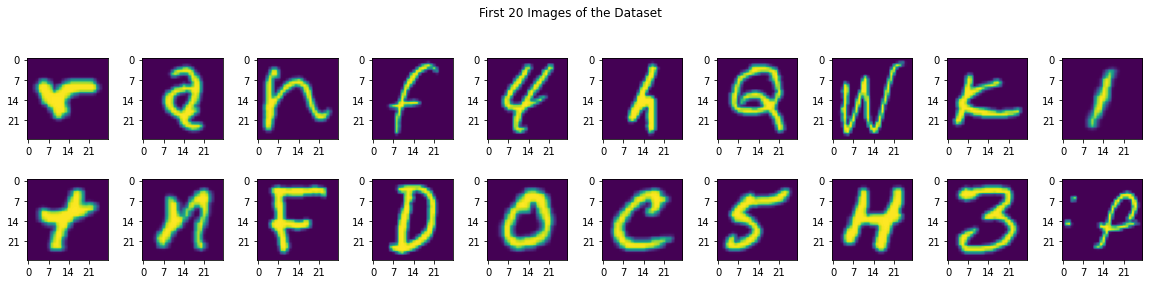

In [9]:
subplot_kwargs = dict(
    xticks=range(0, 28, 7),
    yticks=range(0, 38, 7)
)
fig, axes = plt.subplots(2, 10, figsize=(20, 4), subplot_kw=subplot_kwargs)
fig.subplots_adjust(
    left=0.12,
    bottom=0.1,
    right=0.9,
    top=0.8,
    wspace=0.3,
    hspace=0.5
)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(train_x[idx, ..., 0])

plt.suptitle('First 20 Images of the Dataset')
plt.show()



 ## Setup a small CNN model using `tf.keras.Sequential`

 * A simple convolutional neural network with the structure
 * `32c32p64c64p->200->10`
 * `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$)
   set to `0.005`.

In [10]:
# Fraction of training data to be used for validation



In [11]:
def build_model():
    model = tf.keras.Sequential()

    # FIRST CONVOLUTION LAYER
    model = tf.keras.Sequential(
        [
            Conv2D(
                filters=64,  # 32
                kernel_size=(5, 5),
                strides=(1, 1),
                activation='relu',
                input_shape=(28, 28, 1),
            ),  # The 32 maps are 24x24   # 28-5+1 = 24
            # Dropout(0.1),
            MaxPooling2D(
                pool_size=(2, 2),
                strides=2
            ),  # The 32 pooled maps are 12x12
            Conv2D(
                filters=128,  # 64
                kernel_size=(3, 3),
                strides=(1, 1),
                activation='relu',
            ),  # The 64 maps are 10x10   (12-3+1 = 10)
            MaxPooling2D(
                pool_size=(2, 2),
                strides=2,
            ),  # The 64 pooled maps are 5x5
            Conv2D(
                filters=256,  # 128
                kernel_size=(3, 3),
                strides=(1, 1),
                activation='relu'
            ),  # The 128 maps are 3x3 (5 - 3 + 1)
            Dropout(0.1),
            Flatten(),  # 64x5x5 -> 1600 neuron layer (128x3x3 -> 1152)
            Dense(units=128, activation='relu'),
            Dropout(0.5),
            Dense(units=47, activation='softmax'),
        ]
    )

    return model


def compile_model(model, loss_fcn, optimizer='adam', lr=1e-3):
    if(optimizer == 'adam'):
        optim = tf.keras.optimizers.Adam(lr=lr)
    else:
        optim = tf.keras.optimizers.SGD(lr=lr)

    model.compile(optimizer=optim, loss=loss_fcn, metrics=['accuracy'])
    print(model.summary())
    return None


def fit_model(model, X, y, batch_size, epochs=3, callbacks=None, **fit_kwargs):
    history = model.fit(X,
                        y,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        **fit_kwargs)
    return history


# callback to keras to save best model weights
best_weights = "cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights,
                                                monitor='val_acc',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                            patience=5,
                                            restore_best_weights=False)

model = build_model()
loss_fcn = 'categorical_crossentropy'
optimizer = 'adam'
compile_model(model,
              optimizer=optimizer,
              lr=5e-4,
              loss_fcn='categorical_crossentropy')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 256)         0         
_______________________________________

 ## Train the CNN

In [12]:

# history = fit_model(model,
#                     train_x,
#                     train_y,
#                     batch_size=32,
#                     epochs=3,
#                     callbacks=[checkpoint],
#                     validation_split=0.1)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    # shear_range=10,
    zoom_range=0.2,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zca_whitening=True,
    # zca_epsilon=1e-5,
    validation_split=0.1,
)
datagen.fit(train_x)

bs = 8
train_it = datagen.flow(train_x, train_y, subset='training', batch_size=bs)
val_it = datagen.flow(train_x, train_y, subset='validation', batch_size=bs)
history = model.fit_generator(generator=train_it,
                              steps_per_epoch=int(np.ceil(60e3 * 0.9 / bs)),
                              epochs=15,
                              validation_data=val_it,
                              validation_steps=int(np.ceil(60e3 * 0.1 / bs)),
                              callbacks=[checkpoint, stopping])


Epoch 1/15
 748/6750 [==>...........................] - ETA: 18s - loss: 0.5081 - acc: 0.8307
Epoch 00001: val_acc improved from -inf to 0.83033, saving model to cnn_weights_best.hdf5
6750/6750 [==============================] - 34s 5ms/step - loss: 1.1404 - acc: 0.6580 - val_loss: 0.5097 - val_acc: 0.8303
Epoch 2/15
 736/6750 [==>...........................] - ETA: 17s - loss: 0.4337 - acc: 0.8378
Epoch 00002: val_acc improved from 0.83033 to 0.83800, saving model to cnn_weights_best.hdf5
6750/6750 [==============================] - 31s 5ms/step - loss: 0.6169 - acc: 0.7978 - val_loss: 0.4329 - val_acc: 0.8380
Epoch 3/15
 736/6750 [==>...........................] - ETA: 19s - loss: 0.4139 - acc: 0.8539
Epoch 00003: val_acc improved from 0.83800 to 0.85417, saving model to cnn_weights_best.hdf5
6750/6750 [==============================] - 31s 5ms/step - loss: 0.5239 - acc: 0.8241 - val_loss: 0.4122 - val_acc: 0.8542
Epoch 4/15
 738/6750 [==>...........................] - ETA: 18s - los

 # Test the model at the end

In [13]:
model.evaluate(test_x, test_y, batch_size=bs)
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     # zca_whitening=True,
#     # zca_epsilon=1e-5
# )
# datagen.fit(test_x)
# test_it = datagen.flow(test_x, test_y, batch_size=bs)
# model.evaluate_generator(test_it)



18800/18800 [==============================] - 5s 250us/sample - loss: 0.3551 - acc: 0.8818


[0.35505473793163816, 0.8817553]

 # Test at the best validation accuracy

In [14]:
model.load_weights(best_weights)
model.compile(optimizer=optimizer, loss=loss_fcn, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=bs)
# model.evaluate_generator(test_it)



18800/18800 [==============================] - 5s 248us/sample - loss: 0.3540 - acc: 0.8855


[0.35398416090650725, 0.88547873]

 # Restart the notebook to free up the `GPU` and `RAM`.

In [15]:
# IPython.Application.instance().kernel.do_shutdown(True)  # automatically
# restarts kernel
session.close()

